In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Computational Complexity of the k–Nearest-Neighbor Rule

The computational complexity of the nearest-neighbor (NN) algorithm can be analyzed in terms of **space** (storage requirements for prototypes) and **time** (search operations). In this section, we discuss key techniques to reduce this computational burden.

### Naive Approach

Suppose we have $ n $ labeled training samples in $ d $-dimensional space, and we seek the closest sample to a test point $ \mathbf{x} $ $( k = 1 $):

1. **Naive Search**:
    - For each training sample, compute the Euclidean distance:
      $$
      D(\mathbf{x}, \mathbf{x}_i) = \sqrt{\sum_{k=1}^d (x_k - x_{i,k})^2}.
      $$
    - Retain the sample with the smallest distance.
    - Computational complexity:
      - Distance calculation: $ O(d) $.
      - Search: $ O(dn) $.

2. **Parallel Implementation**:
    - A parallel NN circuit performs the search in $ O(1) $ time.
    - However, this requires $ O(n) $ space for storing prototypes.

### Methods to Reduce Computational Complexity

There are three general approaches to improving the efficiency of NN search:

#### 1. **Partial Distance Calculation**

Instead of calculating the full distance in all $ d $-dimensions, compute a partial distance using only $ r $ dimensions $( r < d $):

$$
D_r(\mathbf{a}, \mathbf{b}) = \left(\sum_{k=1}^r (a_k - b_k)^2 \right)^{1/2}.
$$

- If $ D_r(\mathbf{a}, \mathbf{b}) $ exceeds the smallest distance already found, terminate the computation for that prototype.
- The partial distance is **non-decreasing** as more dimensions are added.

#### 2. **Prestructuring**

Prestructure the data into a search tree. During classification:

1. Compute the distance to an "entry" or "root" prototype.
2. Search only among the prototypes linked to the closest root.

- **Example**: For $ n $ points distributed uniformly in the unit square $ [0, 1]^2 $:
    - Divide the space into quadrants, each with its own root prototype.
    - For a test point $ \mathbf{x} $, search only within the quadrant containing $ \mathbf{x} $.
    - Trade-off: This reduces computational complexity but may fail to find the true nearest neighbor for points near boundaries.

#### 3. **Editing (Pruning)**

Eliminate "useless" prototypes that do not contribute to decision boundaries:

- **Algorithm**:
    1. Construct the Voronoi diagram of the training data.
    2. For each prototype $ \mathbf{x}_j $, check its Voronoi neighbors.
    3. Mark $ \mathbf{x}_j $ if any neighbor belongs to a different class.
    4. Discard unmarked prototypes.
    5. Reconstruct the Voronoi diagram with the reduced set.

- **Complexity**:
    - Voronoi diagram construction: $ O(d^3 n^{d/2} \ln n) $.
    - Reduces storage requirements to $ O(k) $, where $ k $ is the number of boundary prototypes.

#### Combined Approach

We can combine all three methods to achieve significant computational efficiency:

1. Edit the prototypes to reduce storage requirements.
2. Prestructure the data into a search tree.
3. Use partial distance calculation during classification.

### Trade-offs

Each method introduces a trade-off between **accuracy** and **complexity**:

- Partial distance and prestructuring may reduce the likelihood of finding the exact nearest neighbor.
- Editing requires all training data in advance and may not accommodate new data efficiently.

### Conclusion

The computational complexity of NN can be significantly reduced using these methods while maintaining high accuracy in many practical applications.


In [1]:
import numpy as np
from scipy.spatial import KDTree
from sklearn.neighbors import NearestNeighbors

# Generate synthetic data
def generate_data(n_samples=1000, n_features=10):
    """
    Generate synthetic data for nearest-neighbor implementation.
    """
    np.random.seed(42)
    X = np.random.rand(n_samples, n_features)  # Training data
    return X

# 1. Partial Distance Calculation
def partial_distance_knn(X, query, r=5):
    """
    Perform k-NN search with partial distance calculations.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        query (np.ndarray): Query point (n_features,).
        r (int): Number of dimensions to consider for partial distance.
    Returns:
        nearest_idx (int): Index of the nearest neighbor.
        nearest_dist (float): Distance to the nearest neighbor.
    """
    n_samples, n_features = X.shape
    assert r <= n_features, "r must be less than or equal to the number of features."
    
    nearest_idx = -1
    nearest_dist = float("inf")
    
    for i, x in enumerate(X):
        partial_dist = np.sqrt(np.sum((x[:r] - query[:r])**2))
        if partial_dist > nearest_dist:
            continue
        full_dist = np.sqrt(np.sum((x - query)**2))
        if full_dist < nearest_dist:
            nearest_dist = full_dist
            nearest_idx = i
    
    return nearest_idx, nearest_dist

# 2. Prestructuring with KDTree
def kdtree_knn(X, query):
    """
    Perform k-NN search using KDTree for efficient prestructuring.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        query (np.ndarray): Query point (n_features,).
    Returns:
        nearest_idx (int): Index of the nearest neighbor.
        nearest_dist (float): Distance to the nearest neighbor.
    """
    tree = KDTree(X)
    nearest_dist, nearest_idx = tree.query(query, k=1)
    return nearest_idx, nearest_dist

# 3. Editing (Pruning) Prototypes
def edit_prototypes(X, y):
    """
    Perform prototype editing by removing redundant samples.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        y (np.ndarray): Labels corresponding to training data.
    Returns:
        edited_X (np.ndarray): Edited training data.
        edited_y (np.ndarray): Edited labels.
    """
    # Initialize list of marked samples
    marked = np.zeros(X.shape[0], dtype=bool)
    
    # Use nearest neighbors to find neighbors
    nbrs = NearestNeighbors(n_neighbors=5, algorithm="ball_tree").fit(X)
    for i, x in enumerate(X):
        distances, indices = nbrs.kneighbors([x])
        # If all neighbors belong to the same class, mark the sample
        neighbor_classes = y[indices[0]]
        if np.any(neighbor_classes != y[i]):
            marked[i] = True
    
    # Filter marked samples
    edited_X = X[marked]
    edited_y = y[marked]
    return edited_X, edited_y

# Test the methods
if __name__ == "__main__":
    # Generate data
    X = generate_data(n_samples=1000, n_features=10)
    query_point = np.random.rand(10)  # Random test point
    
    # Partial Distance Method
    nearest_idx_pd, nearest_dist_pd = partial_distance_knn(X, query_point, r=5)
    print(f"Partial Distance Method: Nearest Index = {nearest_idx_pd}, Distance = {nearest_dist_pd:.4f}")
    
    # KDTree Prestructuring
    nearest_idx_kdt, nearest_dist_kdt = kdtree_knn(X, query_point)
    print(f"KDTree Method: Nearest Index = {nearest_idx_kdt}, Distance = {nearest_dist_kdt:.4f}")
    
    # Editing (Pruning)
    labels = np.random.randint(0, 2, size=X.shape[0])  # Random binary labels
    edited_X, edited_y = edit_prototypes(X, labels)
    print(f"Edited Prototypes: Original = {X.shape[0]}, Reduced = {edited_X.shape[0]}")


Partial Distance Method: Nearest Index = 454, Distance = 0.4482
KDTree Method: Nearest Index = 454, Distance = 0.4482
Edited Prototypes: Original = 1000, Reduced = 942


Partial Distance Method: Nearest Index = 120, Distance = 0.0730


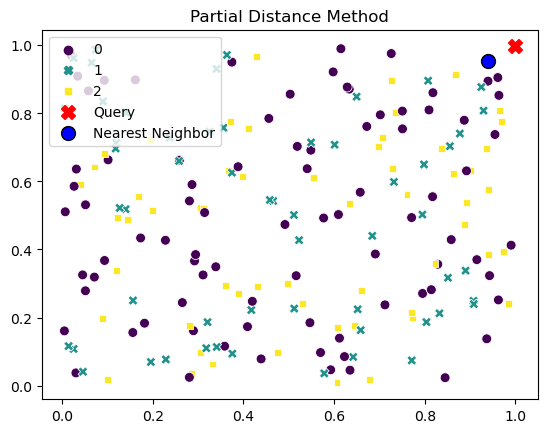

Prestructured Search: Nearest Index = 120, Distance = 0.0730


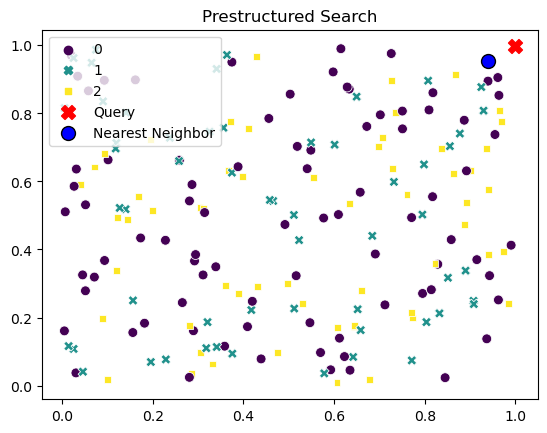

Edited Prototypes: Original = 200, Reduced = 200


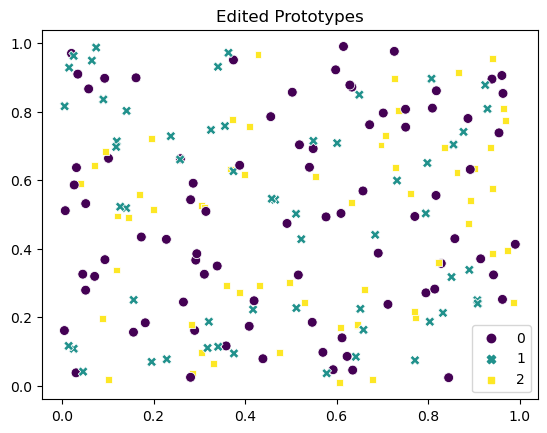

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_data(n_samples=100, n_features=2, n_classes=2):
    """
    Generate synthetic dataset with labels for visualization.
    """
    np.random.seed(42)
    X = np.random.rand(n_samples, n_features)  # Feature matrix
    y = np.random.randint(0, n_classes, n_samples)  # Labels
    return X, y

# 1. Partial Distance Calculation
def partial_distance_knn(X, query, r=1):
    """
    Perform k-NN search with partial distance calculations.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        query (np.ndarray): Query point (n_features,).
        r (int): Number of dimensions to consider for partial distance.
    Returns:
        nearest_idx (int): Index of the nearest neighbor.
        nearest_dist (float): Distance to the nearest neighbor.
    """
    n_samples, n_features = X.shape
    assert r <= n_features, "r must be less than or equal to the number of features."
    
    nearest_idx = -1
    nearest_dist = float("inf")
    
    for i, x in enumerate(X):
        partial_dist = np.sqrt(np.sum((x[:r] - query[:r])**2))
        if partial_dist > nearest_dist:
            continue
        full_dist = np.sqrt(np.sum((x - query)**2))
        if full_dist < nearest_dist:
            nearest_dist = full_dist
            nearest_idx = i
    
    return nearest_idx, nearest_dist

# 2. Prestructuring Using Custom Tree
def prestructure_knn(X, query):
    """
    Perform k-NN search using a naive quadrant-based partitioning.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        query (np.ndarray): Query point (n_features,).
    Returns:
        nearest_idx (int): Index of the nearest neighbor.
        nearest_dist (float): Distance to the nearest neighbor.
    """
    n_samples, n_features = X.shape
    mid_points = np.mean(X, axis=0)
    quadrant_idx = (query >= mid_points).astype(int)
    
    # Select prototypes in the same quadrant
    selected = np.all((X >= mid_points) == quadrant_idx, axis=1)
    if not np.any(selected):
        selected = np.ones(n_samples, dtype=bool)  # Fallback to all
    
    nearest_idx = -1
    nearest_dist = float("inf")
    
    for i, x in enumerate(X[selected]):
        dist = np.sqrt(np.sum((x - query)**2))
        if dist < nearest_dist:
            nearest_dist = dist
            nearest_idx = np.where(selected)[0][i]
    
    return nearest_idx, nearest_dist

# 3. Editing (Pruning) Prototypes
def edit_prototypes(X, y):
    """
    Perform prototype editing by removing redundant samples.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        y (np.ndarray): Labels corresponding to training data.
    Returns:
        edited_X (np.ndarray): Edited training data.
        edited_y (np.ndarray): Edited labels.
    """
    n_samples = X.shape[0]
    marked = np.zeros(n_samples, dtype=bool)
    
    for i in range(n_samples):
        distances = np.sqrt(np.sum((X - X[i])**2, axis=1))
        neighbors = np.argsort(distances)[1:6]  # 5 nearest neighbors excluding self
        if np.any(y[neighbors] != y[i]):
            marked[i] = True
    
    return X[marked], y[marked]

# Visualize results
def visualize_data(X, y, query=None, nearest_idx=None, title=""):
    """
    Visualize the data points and query in 2D.
    """
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="viridis", style=y, s=50)
    if query is not None:
        plt.scatter(query[0], query[1], color="red", label="Query", s=100, marker="X")
    if nearest_idx is not None:
        plt.scatter(X[nearest_idx, 0], X[nearest_idx, 1], color="blue", label="Nearest Neighbor", s=100, edgecolor="black")
    plt.legend()
    plt.title(title)
    plt.show()

# Test the methods
if __name__ == "__main__":
    # Generate data
    X, y = generate_data(n_samples=200, n_features=2, n_classes=3)
    query_point = np.random.rand(2)  # Random query point
    
    # Partial Distance Method
    nearest_idx_pd, nearest_dist_pd = partial_distance_knn(X, query_point, r=1)
    print(f"Partial Distance Method: Nearest Index = {nearest_idx_pd}, Distance = {nearest_dist_pd:.4f}")
    visualize_data(X, y, query_point, nearest_idx_pd, title="Partial Distance Method")
    
    # Prestructuring Method
    nearest_idx_ps, nearest_dist_ps = prestructure_knn(X, query_point)
    print(f"Prestructured Search: Nearest Index = {nearest_idx_ps}, Distance = {nearest_dist_ps:.4f}")
    visualize_data(X, y, query_point, nearest_idx_ps, title="Prestructured Search")
    
    # Editing (Pruning)
    edited_X, edited_y = edit_prototypes(X, y)
    print(f"Edited Prototypes: Original = {X.shape[0]}, Reduced = {edited_X.shape[0]}")
    visualize_data(edited_X, edited_y, title="Edited Prototypes")


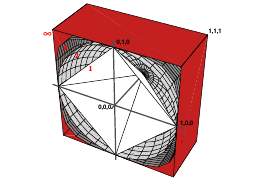

Fig.19: Each colored surface consists of points a distance 1.0 from the origin, measured using diﬀerent values for k in the Minkowski metric (k is printed in red). Thus the white surfaces correspond to the L1 norm (Manhattan distance), light gray the L2 norm (Euclidean distance), dark gray the L4 norm, and red the L∞ norm.

/home/radha/anaconda3/envs/cv37/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: No contour levels were found within the data range.


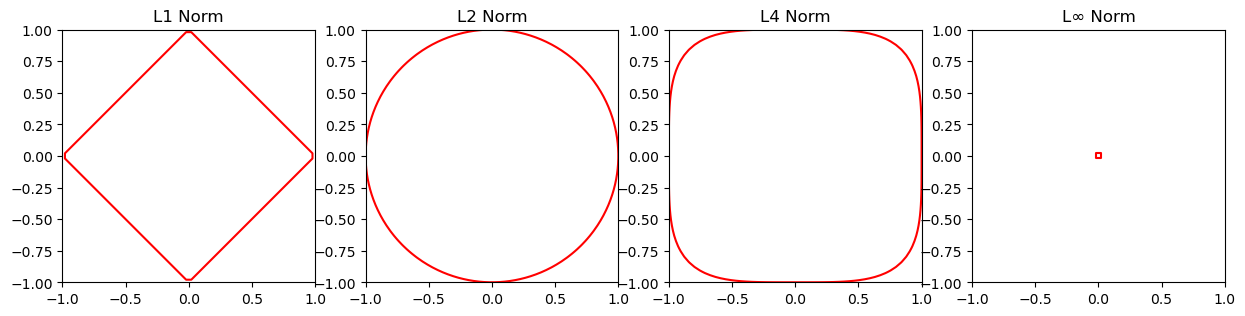

Data has been scaled.


TypeError: minkowski_distance() got an unexpected keyword argument 'p'

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Generate synthetic data
def generate_data(n_samples=100, n_features=2, n_classes=3):
    """
    Generate synthetic data points with labels.
    """
    np.random.seed(42)
    X = np.random.rand(n_samples, n_features)  # Feature matrix
    y = np.random.randint(0, n_classes, n_samples)  # Labels
    return X, y

# Minkowski Metrics
def minkowski_distance(a, b, k=2):
    """
    Compute the Minkowski distance between two points.
    Args:
        a (np.ndarray): Point 1.
        b (np.ndarray): Point 2.
        k (int): Order of the Minkowski metric.
    Returns:
        float: Minkowski distance.
    """
    return np.sum(np.abs(a - b) ** k) ** (1 / k)

def tanimoto_distance(S1, S2):
    """
    Compute the Tanimoto distance between two sets.
    Args:
        S1 (set): Set 1.
        S2 (set): Set 2.
    Returns:
        float: Tanimoto distance.
    """
    n1, n2 = len(S1), len(S2)
    n12 = len(S1 & S2)
    return (n1 + n2 - 2 * n12) / (n1 + n2 - n12)

# Visualization of Minkowski Metrics
def visualize_minkowski_metrics(k_values=[1, 2, 4, np.inf], grid_size=50):
    """
    Visualize unit distances for different Minkowski metrics.
    """
    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, y)

    fig, axes = plt.subplots(1, len(k_values), figsize=(15, 4))
    for i, k in enumerate(k_values):
        if np.isinf(k):  # L∞ norm
            D = np.maximum(np.abs(X), np.abs(Y))
        else:  # Lk norm
            D = (np.abs(X) ** k + np.abs(Y) ** k) ** (1 / k)
        
        axes[i].contour(X, Y, D, levels=[1], colors='red')
        axes[i].set_title(f"L{k if not np.isinf(k) else '∞'} Norm")
        axes[i].set_aspect('equal')

    plt.show()

# Scaling Data
def scale_data(X):
    """
    Scale data to have zero mean and unit variance along each axis.
    """
    return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# k-Nearest Neighbor Classifier with Custom Metric
#def knn_classify(X, y, query, k=3, metric=minkowski_distance, **kwargs):
    """
    Perform k-NN classification with a custom metric.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        y (np.ndarray): Training labels.
        query (np.ndarray): Query point (n_features,).
        k (int): Number of neighbors.
        metric (callable): Distance function.
        kwargs: Additional arguments for the metric.
    Returns:
        int: Predicted class.
    """
def knn_classify(X, y, query, k=3, metric=minkowski_distance, **kwargs):
    """
    Perform k-NN classification with a custom metric.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        y (np.ndarray): Training labels.
        query (np.ndarray): Query point (n_features,).
        k (int): Number of neighbors.
        metric (callable): Distance function.
        kwargs: Additional arguments for the metric.
    Returns:
        int: Predicted class.
    """
    distances = np.array([metric(query, x, **kwargs) for x in X])
    nearest_neighbors = np.argsort(distances)[:k]
    nearest_labels = y[nearest_neighbors]
    return np.bincount(nearest_labels).argmax()


# Test the Metrics and Classifier
if __name__ == "__main__":
    # Generate data
    X, y = generate_data(n_samples=200, n_features=2, n_classes=3)
    query_point = np.random.rand(2)  # Random query point

    # Visualize Minkowski Metrics
    visualize_minkowski_metrics()

    # Scale the data to equalize ranges
    scaled_X = scale_data(X)
    print("Data has been scaled.")

    # Classification with L2 (Euclidean) Metric
    pred_class_l2 = knn_classify(scaled_X, y, query_point, k=5, metric=minkowski_distance, p=2)
    print(f"Predicted Class (L2): {pred_class_l2}")

    # Classification with L1 (Manhattan) Metric
    pred_class_l1 = knn_classify(scaled_X, y, query_point, k=5, metric=minkowski_distance, p=1)
    print(f"Predicted Class (L1): {pred_class_l1}")

    # Visualization of data
    sns.scatterplot(x=scaled_X[:, 0], y=scaled_X[:, 1], hue=y, palette="viridis", style=y, s=50)
    plt.scatter(query_point[0], query_point[1], color="red", label="Query", s=100, marker="X")
    plt.legend()
    plt.title("Scaled Data with Query Point")
    plt.show()


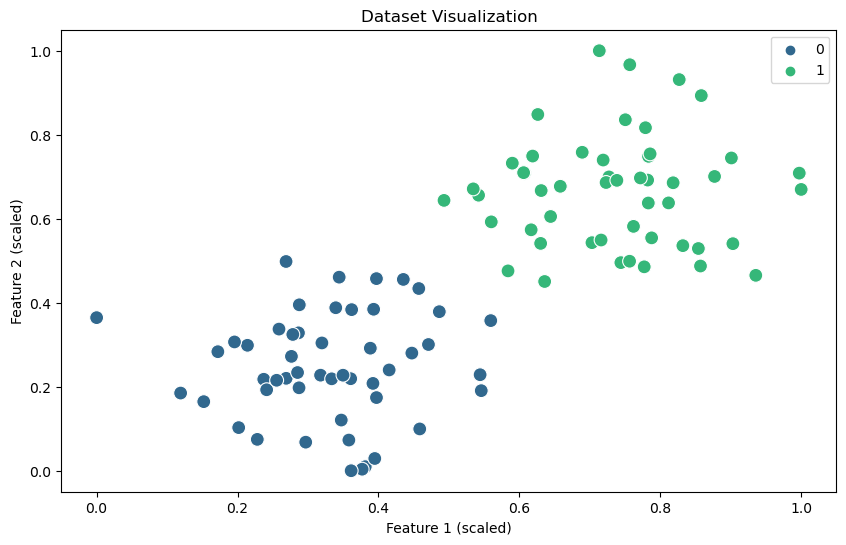

Predicted Class (L2): 0
Predicted Class (L1): 0


In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Define the Minkowski distance function
def minkowski_distance(a, b, p=2):
    """
    Calculate Minkowski distance between two points.
    Args:
        a (np.ndarray): First point.
        b (np.ndarray): Second point.
        p (float): Power parameter for Minkowski metric.
    Returns:
        float: The Minkowski distance.
    """
    return np.sum(np.abs(a - b) ** p) ** (1 / p)

# k-NN classification function
def knn_classify(X, y, query, k=3, metric=minkowski_distance, **kwargs):
    """
    Perform k-NN classification with a custom metric.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        y (np.ndarray): Training labels.
        query (np.ndarray): Query point (n_features,).
        k (int): Number of neighbors.
        metric (callable): Distance function.
        kwargs: Additional arguments for the metric.
    Returns:
        int: Predicted class.
    """
    # Compute distances using the provided metric
    distances = np.array([metric(query, x, **kwargs) for x in X])
    # Get indices of k nearest neighbors
    nearest_neighbors = np.argsort(distances)[:k]
    # Extract the labels of the nearest neighbors
    nearest_labels = y[nearest_neighbors]
    # Return the most common label
    return np.bincount(nearest_labels).argmax()

# Generate synthetic dataset
np.random.seed(42)
X_class0 = np.random.normal(loc=0, scale=1, size=(50, 2))
X_class1 = np.random.normal(loc=3, scale=1, size=(50, 2))
X = np.vstack((X_class0, X_class1))
y = np.array([0] * 50 + [1] * 50)

# Scale features
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_X[:, 0], y=scaled_X[:, 1], hue=y, palette="viridis", s=100)
plt.title("Dataset Visualization")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()

# Query point
query_point = np.array([0.6, 0.3])

# Testing with L2 (Euclidean) Metric
pred_class_l2 = knn_classify(scaled_X, y, query_point, k=5, metric=minkowski_distance, p=2)
print(f"Predicted Class (L2): {pred_class_l2}")

# Testing with L1 (Manhattan) Metric
pred_class_l1 = knn_classify(scaled_X, y, query_point, k=5, metric=minkowski_distance, p=1)
print(f"Predicted Class (L1): {pred_class_l1}")


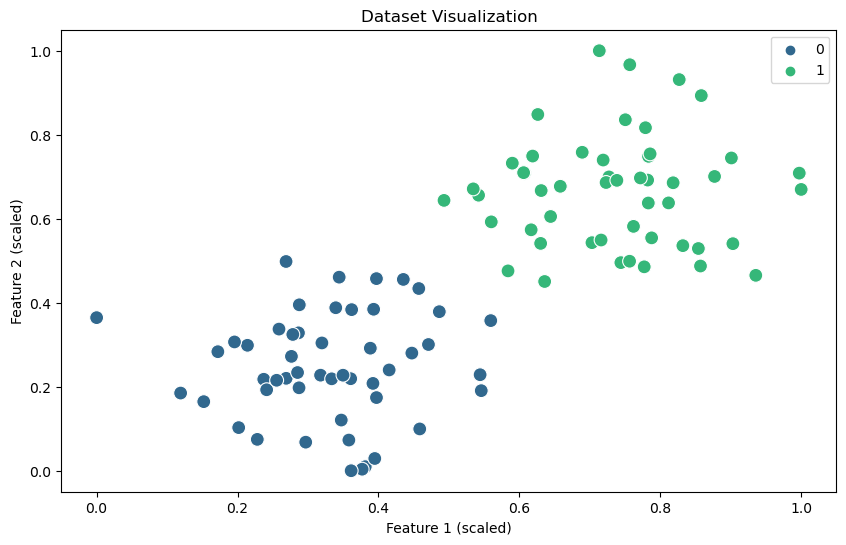

Predicted Class (L2): 0
Predicted Class (L1): 0


In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

# Define the Minkowski distance function
def minkowski_distance(a, b, p=2):
    """
    Calculate Minkowski distance between two points.
    Args:
        a (np.ndarray): First point.
        b (np.ndarray): Second point.
        p (float): Power parameter for Minkowski metric.
    Returns:
        float: The Minkowski distance.
    """
    return np.sum(np.abs(a - b) ** p) ** (1 / p)

# k-NN classification function
def knn_classify(X, y, query, k=3, metric=minkowski_distance, **kwargs):
    """
    Perform k-NN classification with a custom metric.
    Args:
        X (np.ndarray): Training data (n_samples, n_features).
        y (np.ndarray): Training labels.
        query (np.ndarray): Query point (n_features,).
        k (int): Number of neighbors.
        metric (callable): Distance function.
        kwargs: Additional arguments for the metric.
    Returns:
        int: Predicted class.
    """
    # Compute distances using the provided metric
    distances = np.array([metric(query, x, **kwargs) for x in X])
    # Get indices of k nearest neighbors
    nearest_neighbors = np.argsort(distances)[:k]
    # Extract the labels of the nearest neighbors
    nearest_labels = y[nearest_neighbors]
    # Return the most common label
    return np.bincount(nearest_labels).argmax()

# Generate synthetic dataset
np.random.seed(42)
X_class0 = np.random.normal(loc=0, scale=1, size=(50, 2))
X_class1 = np.random.normal(loc=3, scale=1, size=(50, 2))
X = np.vstack((X_class0, X_class1))
y = np.array([0] * 50 + [1] * 50)

# Scale features
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

# Visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_X[:, 0], y=scaled_X[:, 1], hue=y, palette="viridis", s=100)
plt.title("Dataset Visualization")
plt.xlabel("Feature 1 (scaled)")
plt.ylabel("Feature 2 (scaled)")
plt.show()

# Query point
query_point = np.array([0.6, 0.3])

# Testing with L2 (Euclidean) Metric
pred_class_l2 = knn_classify(scaled_X, y, query_point, k=5, metric=minkowski_distance, p=2)
print(f"Predicted Class (L2): {pred_class_l2}")

# Testing with L1 (Manhattan) Metric
pred_class_l1 = knn_classify(scaled_X, y, query_point, k=5, metric=minkowski_distance, p=1)
print(f"Predicted Class (L1): {pred_class_l1}")


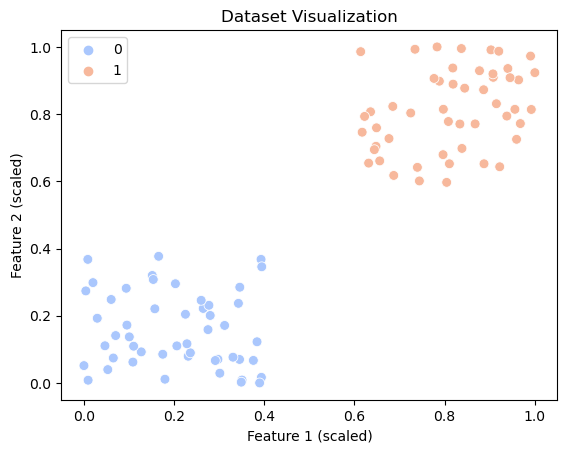

Predicted Class (L2): 1
Predicted Class (L1): 1


In [8]:
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Minkowski Distance Function
def minkowski_distance(a, b, p=2):
    """
    Calculate the Minkowski distance between two points.
    Args:
        a (list): First point.
        b (list): Second point.
        p (int): Power parameter for the Minkowski metric.
    Returns:
        float: Distance between a and b.
    """
    return sum(abs(ai - bi) ** p for ai, bi in zip(a, b)) ** (1 / p)

# Min-Max Scaling Function
def min_max_scale(data):
    """
    Scale data to a 0-1 range.
    Args:
        data (list of lists): Input data.
    Returns:
        list of lists: Scaled data.
    """
    min_vals = [min(col) for col in zip(*data)]
    max_vals = [max(col) for col in zip(*data)]
    return [[(val - min_val) / (max_val - min_val) if max_val > min_val else 0 
             for val, min_val, max_val in zip(row, min_vals, max_vals)]
            for row in data]

# k-Nearest Neighbors Classification Function
def knn_classify(X, y, query, k=3, metric=minkowski_distance, **kwargs):
    """
    Perform k-NN classification.
    Args:
        X (list of lists): Training data.
        y (list): Labels for training data.
        query (list): Query point.
        k (int): Number of neighbors.
        metric (function): Distance function.
        kwargs: Additional arguments for the distance function.
    Returns:
        int: Predicted class label.
    """
    # Calculate distances
    distances = [(metric(query, x, **kwargs), label) for x, label in zip(X, y)]
    # Sort distances and get labels of k nearest neighbors
    distances.sort(key=lambda d: d[0])
    nearest_labels = [label for _, label in distances[:k]]
    # Return the most common label
    return Counter(nearest_labels).most_common(1)[0][0]

# Generate Synthetic Data
def generate_data():
    """
    Generate synthetic data with two classes.
    Returns:
        list, list: Features and labels.
    """
    X_class0 = [[random.uniform(0, 2), random.uniform(0, 2)] for _ in range(50)]
    X_class1 = [[random.uniform(3, 5), random.uniform(3, 5)] for _ in range(50)]
    X = X_class0 + X_class1
    y = [0] * 50 + [1] * 50
    return X, y

# Main Script
if __name__ == "__main__":
    # Generate data and scale it
    X, y = generate_data()
    scaled_X = min_max_scale(X)

    # Visualize the dataset
    x1 = [point[0] for point in scaled_X]
    x2 = [point[1] for point in scaled_X]
    sns.scatterplot(x=x1, y=x2, hue=y, palette="coolwarm", s=50)
    plt.title("Dataset Visualization")
    plt.xlabel("Feature 1 (scaled)")
    plt.ylabel("Feature 2 (scaled)")
    plt.show()

    # Query point
    query_point = [0.5, 0.5]

    # Classification with L2 (Euclidean) metric
    pred_class_l2 = knn_classify(scaled_X, y, query_point, k=5, metric=minkowski_distance, p=2)
    print(f"Predicted Class (L2): {pred_class_l2}")

    # Classification with L1 (Manhattan) metric
    pred_class_l1 = knn_classify(scaled_X, y, query_point, k=5, metric=minkowski_distance, p=1)
    print(f"Predicted Class (L1): {pred_class_l1}")


##  Tangent Distance

There may be drawbacks inherent in the uncritical use of a particular metric in nearest-neighbor classifiers, and these drawbacks can be overcome by the careful use of more general measures of distance. 

One crucial problem is that of **invariance**. Consider a 100-dimensional pattern $ x $ representing a $ 10 \times 10 $ pixel grayscale image of a handwritten 5. Now consider the Euclidean distance from $ x $ to the pattern representing an image shifted horizontally but otherwise identical. Even if the relative shift is a mere three pixels, the Euclidean distance grows very large—much greater than the distance to an unshifted 8. Clearly, the Euclidean metric is of little use in a nearest-neighbor classifier that must be insensitive to such translations.

### Challenges with Euclidean Distance

Likewise, other transformations, such as overall rotation or scaling of the image, would not be well accommodated by the Euclidean distance. Such drawbacks are especially pronounced if we demand that our classifier be simultaneously invariant to several transformations, such as:

- Horizontal translation
- Vertical translation
- Overall scale
- Rotation
- Line thickness
- Shear

While preprocessing the images (e.g., centering, scaling, etc.) can help, it has its own challenges, such as sensitivity to outliers or noise. Alternatives to preprocessing are explored here.

---
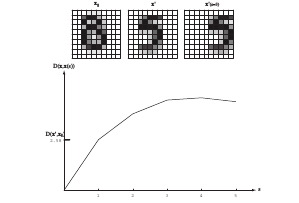

Fig.20: The uncritical use of Euclidean metric cannot address the problem of translation invariance. Pattern x represents a handwritten 5, and x (s = 3) the same shape but shifted three pixels to the right. The Euclidean distance D(x , x (s = 3)) is much larger than D(x , x8 ), where x8 represents the handwritten 8. Nearest-neighbor classiﬁcation based on the Euclidean distance in this way leads to very large errors. Instead, we seek a distance measure that would be insensitive to such translations, or indeed other known invariances, such as scale or rotation.

### Tangent Distance Classifiers

To address these challenges, we use a novel distance measure: **Tangent Distance**. This involves a linear approximation of arbitrary transformations.

#### Linear Approximation of Transformations

Suppose there are $ r $ transformations applicable to our problem (e.g., horizontal translation, vertical translation, shear, rotation, etc.). During classifier construction:

1. Each stored prototype $ x $ undergoes a transformation $ F_i(x; \alpha_i) $. For example, $ F_i(x; \alpha_i) $ could represent the image rotated by a small angle $ \alpha_i $.

2. For each transformation, we construct a **tangent vector**:
   $$
   TV_i = F_i(x; \alpha_i) - x
   $$
   
3. This produces an $ r \times d $ matrix $ T $, where $ r $ is the number of transformations and $ d $ is the feature dimensionality. These tangent vectors are assumed to be linearly independent.

#### Tangent Space Representation

Each point in the subspace spanned by the $ r $ tangent vectors passing through $ x $ represents the linearized approximation to the full combination of transforms. During classification, we search for the point in the tangent space closest to a test point $ x $—the linear approximation to the ideal.

---

### Tangent Distance Computation

Given a matrix $ T $ (the tangent vectors at $ x $), the tangent distance from $ x $ to a test point $ x' $ is defined as:

$$
D_{\text{tan}}(x, x') = \min_a \| (x + T a) - x' \|
$$

This describes the **one-sided tangent distance**, where only one pattern $ x $ is transformed. In the two-sided version, both $ x $ and $ x' $ are transformed, but this increases computational complexity.

#### Optimization via Gradient Descent

To minimize the distance, we find the optimal parameter $ a $. The squared Euclidean distance is:

$$
D^2(x + T a, x') = \| (x + T a) - x' \|^2
$$

The gradient with respect to $ a $ is:

$$
\nabla_a D^2(x + T a, x') = 2 T^\top \left( (x + T a) - x' \right)
$$

The parameter vector $ a $ is updated iteratively:

$$
a^{(t+1)} = a^{(t)} - \eta T^\top \left( T a^{(t)} + x - x' \right)
$$

where $ \eta $ is the step size controlling the rate of convergence.

---

### Remarks on Tangent Distance

1. **Binary Images**: Tangent distance is unsuitable for binary images due to the lack of a proper derivative. In such cases, images are blurred before applying the tangent distance classifier.

2. **Computational Complexity**: Constructing tangent vectors for transformations is compute-intensive but done only during training.

3. **Efficiency**: During classification, the search for the optimal point in the tangent space is relatively fast.


Tangent Distance between x and x': 0.9761837050210108


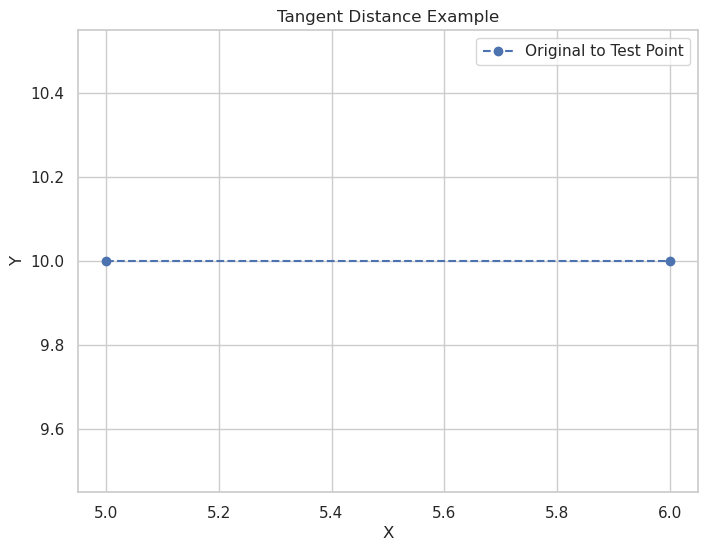

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Helper function to compute Euclidean distance
def euclidean_distance(x, y):
    return sum((a - b)**2 for a, b in zip(x, y)) ** 0.5

# Tangent distance computation
def tangent_distance(x, x_prime, T):
    """
    Compute the tangent distance between x and x_prime given the tangent vectors matrix T.
    This is a simplified version of tangent distance that minimizes the Euclidean distance.
    
    Args:
    - x (list): Prototype point.
    - x_prime (list): Test point.
    - T (list of lists): Tangent vectors matrix.
    
    Returns:
    - float: Tangent distance.
    """
    # Initial guess for parameter a
    a = [0] * len(T[0])
    
    # Gradient descent parameters
    eta = 0.01  # Learning rate
    num_iterations = 100  # Number of iterations
    
    # Function to calculate the Euclidean distance
    def calc_distance(x_prime, x, T, a):
        x_transformed = [xi + sum(T[i][j] * a[j] for j in range(len(a))) for i, xi in enumerate(x)]
        return euclidean_distance(x_transformed, x_prime)
    
    # Gradient descent loop
    for _ in range(num_iterations):
        # Calculate the current distance
        current_distance = calc_distance(x_prime, x, T, a)
        
        # Compute the gradient
        gradient = [0] * len(a)
        for i in range(len(a)):
            # Compute derivative of squared distance with respect to each a_i
            gradient[i] = 2 * sum(T[j][i] * (x[i] + sum(T[j][k] * a[k] for k in range(len(a))) - x_prime[i]) for j in range(len(T)))
        
        # Update the parameter vector a
        for i in range(len(a)):
            a[i] -= eta * gradient[i]
    
    # Return the final distance after optimization
    return calc_distance(x_prime, x, T, a)

# Function to compute the tangent vectors matrix (simplified)
def compute_tangent_vectors(x, transformations):
    """
    Compute the tangent vectors at a given point x based on specified transformations.
    
    Args:
    - x (list): The prototype point.
    - transformations (list): List of transformations, each represented as a function.
    
    Returns:
    - list of lists: Tangent vectors for each transformation.
    """
    tangent_vectors = []
    
    for transform in transformations:
        # Apply the transformation
        transformed_x = transform(x)
        # Compute the tangent vector as the difference between the transformed and original point
        tangent_vector = [t - xi for t, xi in zip(transformed_x, x)]
        tangent_vectors.append(tangent_vector)
    
    return tangent_vectors

# Example transformation functions
def translate_x(x, shift=1):
    """Simple translation function to shift the vector by 'shift' units."""
    return [xi + shift for xi in x]

def rotate_x(x, angle=15):
    """Simple rotation (just for demonstration purposes, assumes angle in degrees)."""
    import math
    angle_rad = math.radians(angle)
    return [x[0] * math.cos(angle_rad) - x[1] * math.sin(angle_rad), x[0] * math.sin(angle_rad) + x[1] * math.cos(angle_rad)]

# Define a simple prototype and test point
x = [5, 10]  # Prototype
x_prime = [6, 10]  # Test point

# Define transformations: translation and rotation
transformations = [lambda x: translate_x(x, shift=2), lambda x: rotate_x(x, angle=10)]

# Compute tangent vectors
T = compute_tangent_vectors(x, transformations)

# Compute tangent distance between the prototype and test point
tangent_dist = tangent_distance(x, x_prime, T)

# Output result
print(f"Tangent Distance between x and x': {tangent_dist}")

# Plot a simple visualization of the transformation
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
plt.plot([x[0], x_prime[0]], [x[1], x_prime[1]], label="Original to Test Point", marker='o', linestyle='--')
plt.title("Tangent Distance Example")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
import random


# Helper function to compute Euclidean distance
def euclidean_distance(x, y):
    return np.sqrt(np.sum((np.array(x) - np.array(y))**2))


# Transformation functions (to create tangent vectors)
def translate_x(image, shift=2):
    """Shift the image horizontally by 'shift' pixels"""
    image_reshaped = image.reshape(28, 28)  # Reshape image to 2D (28x28)
    shifted_image = np.roll(image_reshaped, shift, axis=1)  # Shift along axis 1 (columns)
    return shifted_image.flatten()  # Flatten back to 1D


def rotate_x(image, angle=15):
    """Rotate the image by a specified angle (in degrees)"""
    image_reshaped = Image.fromarray(image.reshape(28, 28))
    rotated_image = image_reshaped.rotate(angle)
    rotated_image_resized = rotated_image.resize((28, 28))  # Resize back to 28x28
    return np.array(rotated_image_resized).flatten()


def scale_x(image, scale=1.2):
    """Scale the image by a factor"""
    image_reshaped = Image.fromarray(image.reshape(28, 28))
    width, height = image_reshaped.size
    new_size = int(width * scale), int(height * scale)
    scaled_image = image_reshaped.resize(new_size)
    scaled_image_resized = scaled_image.resize((28, 28))  # Resize back to 28x28
    return np.array(scaled_image_resized).flatten()


def shear_x(image, shear=0.2):
    """Shear the image"""
    matrix = [1, shear, 0, 0, 1, 0]  # Simple shear matrix
    image_reshaped = Image.fromarray(image.reshape(28, 28))
    sheared_image = image_reshaped.transform(image_reshaped.size, Image.AFFINE, matrix)
    sheared_image_resized = sheared_image.resize((28, 28))  # Resize back to 28x28
    return np.array(sheared_image_resized).flatten()


# Compute Tangent Vectors for a given prototype image
def compute_tangent_vectors(image, transformations):
    tangent_vectors = []
    
    for transform in transformations:
        transformed_image = transform(image)
        tangent_vector = transformed_image - image
        tangent_vectors.append(tangent_vector)
    
    return np.array(tangent_vectors)


# Tangent Distance Calculation
def tangent_distance(x, x_prime, T):
    """Compute the tangent distance between x and x_prime"""
    a = np.zeros(T.shape[1])  # Initial guess for parameter a
    
    # Gradient descent parameters
    eta = 0.01  # Learning rate
    num_iterations = 100  # Number of iterations
    
    # Gradient descent loop
    for _ in range(num_iterations):
        # Calculate the current distance
        x_transformed = x + np.dot(T, a)
        current_distance = np.linalg.norm(x_transformed - x_prime)
        
        # Compute the gradient
        gradient = 2 * np.dot(T.T, x_transformed - x_prime)
        
        # Update the parameter vector a
        a -= eta * gradient
    
    return np.linalg.norm(x + np.dot(T, a) - x_prime)


# Load MNIST dataset
mnist = fetch_openml('mnist_784')

# Prepare the dataset
X = mnist.data.values / 255.0  # Normalize the pixel values to [0,1]
y = mnist.target.astype(int)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select a prototype image and create transformations
prototype_image = X_train[random.randint(0, len(X_train))]

# Define transformations
transformations = [lambda x: translate_x(x, shift=2),
                   lambda x: rotate_x(x, angle=15),
                   lambda x: scale_x(x, scale=1.2),
                   lambda x: shear_x(x, shear=0.2)]

# Compute tangent vectors for the prototype image
T = compute_tangent_vectors(prototype_image, transformations)

# Choose a test image
test_image = X_test[random.randint(0, len(X_test))]

# Compute the tangent distance between the prototype image and the test image
tangent_dist = tangent_distance(prototype_image, test_image, T)

# Output result
print(f"Tangent Distance between prototype and test image: {tangent_dist}")

# Visualize the images
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(prototype_image.reshape(28, 28), cmap='gray')
ax[0].set_title("Prototype Image")
ax[1].imshow(test_image.reshape(28, 28), cmap='gray')
ax[1].set_title("Test Image")
plt.show()


## Tangent Distance: Mathematical Formulation and Concept

The tangent distance method addresses the issue of invariance to transformations, such as rotation and thinning, in nearest-neighbor classifiers. This method ensures that the classifier is robust to transformations like rotation, translation, shear, and scaling by using a linear approximation of the transformation space. The key idea is to compute the **tangent vectors** at each prototype image, which represent the derivatives of the transformation at a given point.

## Transformations and Tangent Vectors

Consider a prototype image $ x_0 $. If we apply a series of transformations to it, we get a new set of images. These transformations can include rotation, line thinning, or other image manipulations. The tangent vectors $ TV_1 $ and $ TV_2 $ are computed by examining the local linear approximation of the transformed images.

We can visualize the result in the following figure:

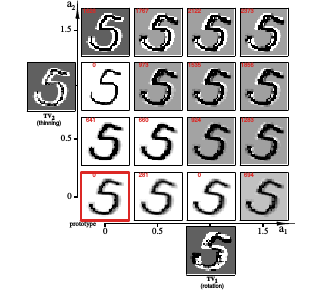

Fig.21: The pixel image of the handwritten 5 prototype at the lower left was subjected to two transformations, rotation, and line thinning, to obtain the tangent vectors TV1 and TV2 ; images corresponding to these tangent vectors are shown out- side the axes. Each of the 16 images within the axes represents the prototype plus linear combination of the two tangent vectors with coeﬃcients a1 and a2 . The small red number in each image is the Euclidean distance between the tangent approxi- mation and the image generated by the unapproximated transformations. Of course, this Euclidean distance is 0 for the prototype and for the cases a1 = 1, a2 = 0 and a1 = 0, a2 = 1. (The patterns generated with a1 + a2 > 1 have a gray background because of automatic grayscale conversion of images with negative pixel values.)

$$
\text{Figure 4.21: Tangent Vectors and Linear Combinations}
$$

This figure shows how the prototype image is modified by transformations, with the tangent vectors $ TV_1 $ (rotation) and $ TV_2 $ (thinning) creating new image variations. Each of the 16 images in the axes represents a linear combination of these tangent vectors, parameterized by coefficients $ a_1 $ and $ a_2 $.

$$
\text{Prototype Image:} \, \text{Lower left corner of the image}
$$

The small red number in each image indicates the **Euclidean distance** between the linear approximation (from the tangent space) and the actual image after transformation. The Euclidean distance is minimized for the prototype and the extreme cases where $ a_1 = 1, a_2 = 0 $ and $ a_1 = 0, a_2 = 1 $.

---

## Tangent Distance Minimization

The **tangent distance** between a prototype image $ x_0 $ and a transformed image $ x' $ can be defined mathematically as the **Euclidean distance** from $ x' $ to the tangent space of $ x_0 $. This can be expressed as:

$$
D_{\text{tan}}(x_0, x) = \min \| x_0 + T \cdot a - x \|
$$

Where:
- $ x_0 $ is the prototype image.
- $ T $ is the matrix of tangent vectors at $ x_0 $.
- $ a $ is the vector of coefficients defining the linear combination of the tangent vectors.

The minimization of this distance is a quadratic problem, where the solution can be found using **gradient descent**.

The squared Euclidean distance between $ x_0 + T \cdot a $ and $ x $ is:

$$
D^2(x_0 + T \cdot a, x) = \| (x_0 + T \cdot a) - x \|^2
$$

The gradient of this distance with respect to the parameter vector $ a $ is:

$$
\nabla_a D^2(x_0 + T \cdot a, x) = 2 T^T \cdot (x_0 + T \cdot a - x)
$$

By performing **gradient descent**, we iteratively update $ a $ to minimize the distance. The update rule is:

$$
a(t+1) = a(t) - \eta T^T \cdot (T \cdot a(t) + x_0 - x)
$$

Where:
- $ \eta $ is the **learning rate** controlling the step size in each iteration.
- $ T^T $ is the transpose of the tangent matrix.

---

## Tangent Distance Visualization

The concept of the tangent space can be visualized as a **subspace** of the high-dimensional space of all possible images. This subspace is spanned by the tangent vectors, such as $ TV_1 $ and $ TV_2 $. The tangent distance corresponds to the minimum distance from a test point $ x $ to this subspace.

In the figure below:

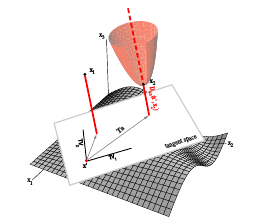

Fig.22: A stored prototype x , if transformed by combinations of two basic transformations, would fall somewhere on a complicated curved surface in the full d-dimensional space (gray). The tangent space at x is an r-dimensional Euclidean space, spanned by the tangent vectors (here TV1 and TV2 ). The tangent distance Dtan (x , x) is the smallest Euclidean distance from x to the tangent space of x , shown in the solid red lines for two points, x1 and x2 . Thus although the Euclidean distance from x to x1 is less than to x2 , for the tangent distance the situation is reversed. The Euclidean distance from x2 to the tangent space of x is a quadratic function of the parameter vector a, as shown by the pink paraboloid. Thus simple gradient descent methods can ﬁnd the optimal vector a and hence the tangent distance Dtan (x , x2 ).

$$
\text{Figure 4.22: Tangent Space and Tangent Distance}
$$

The prototype image $ x_0 $ is transformed by combinations of two basic transformations, $ TV_1 $ (rotation) and $ TV_2 $ (thinning). The images generated by these transformations lie on a **curved surface** in the full image space. The tangent space at $ x_0 $ is an **r-dimensional Euclidean space** (here, spanned by $ TV_1 $ and $ TV_2 $).

The **tangent distance** $ D_{\text{tan}}(x_0, x) $ is the shortest Euclidean distance from the test image $ x $ to this tangent space. The quadratic nature of the Euclidean distance within the tangent space allows us to apply **gradient descent** to find the optimal coefficients $ a $, minimizing the tangent distance.

---

## Conclusion

Using the tangent distance method, we can achieve **invariance** to transformations like rotation, translation, and thinning by representing transformations as tangent vectors and calculating distances within the tangent space. This approach provides an elegant and computationally feasible alternative to preprocessing transformations, improving the robustness of nearest-neighbor classifiers.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import rotate, rescale, warp
from skimage.draw import rectangle
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load dataset (MNIST or similar)
# Fetch the dataset from openml or use an image of your choice
# In this case, we're using a simple dataset from fetch_openml (MNIST)

# Example: Using the MNIST dataset (handwritten digits)
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32).values
y = mnist.target.astype(int).values

# For the sake of simplicity, use the first 100 samples for demonstration
X_samples = X[:100].values
y_samples = y[:100]

# Reshape images to 28x28
images = X_samples.reshape(-1, 28, 28)

# Simple image transformation functions

# Horizontal translation by 'shift' pixels
def translate_x(image, shift=2):
    return np.roll(image, shift, axis=1)

# Rotation of the image by a given 'angle'
def rotate_x(image, angle=15):
    return rotate(image, angle, mode='wrap')

# Scale the image by a given factor
def scale_x(image, scale=1.2):
    return rescale(image, scale)

# Thin the image (simulate line thinning effect)
def thin_x(image, factor=0.5):
    return image * factor  # Simple thinning by scaling pixel values

# Compute tangent vectors for each transformation (translation, rotation, scale)
def compute_tangent_vectors(image, transformations):
    tangent_vectors = []
    for transform in transformations:
        transformed_image = transform(image)
        tangent_vector = transformed_image - image
        tangent_vectors.append(tangent_vector)
    return np.stack(tangent_vectors, axis=0)

# Calculate tangent distance (Euclidean distance to tangent space)
def tangent_distance(image, prototype_image, transformations):
    tangent_vectors = compute_tangent_vectors(prototype_image, transformations)
    
    # Create the tangent matrix T
    T = tangent_vectors.T  # Shape: (d, r) where r = number of transformations
    
    # Compute the tangent distance
    a = np.linalg.lstsq(T, (image - prototype_image).flatten(), rcond=None)[0]
    
    # Reconstruct the image using the tangent space and coefficients a
    reconstructed_image = prototype_image + np.dot(T, a).reshape(prototype_image.shape)
    
    # Compute Euclidean distance between reconstructed image and test image
    distance = np.linalg.norm(reconstructed_image - image)
    
    return distance

# Select a prototype image for demonstration (first image)
prototype_image = images[0]

# Define transformations (translation, rotation, scaling)
transformations = [
    lambda x: translate_x(x, shift=2),
    lambda x: rotate_x(x, angle=15),
    lambda x: scale_x(x, scale=1.2),
    lambda x: thin_x(x, factor=0.5)
]

# Choose a test image (second image)
test_image = images[1]

# Compute the tangent distance to the prototype image
distance = tangent_distance(test_image, prototype_image, transformations)

# Output the result
print(f"Tangent distance between test image and prototype image: {distance}")

# Visualize the prototype and test image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(prototype_image, cmap='gray')
plt.title("Prototype Image")
plt.subplot(1, 2, 2)
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage.transform import rotate, rescale, warp
from skimage.draw import rectangle
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load dataset (MNIST or similar)
# Fetch the dataset from openml or use an image of your choice
# In this case, we're using a simple dataset from fetch_openml (MNIST)

# Example: Using the MNIST dataset (handwritten digits)
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32).values
y = mnist.target.astype(int).values

# For the sake of simplicity, use the first 100 samples for demonstration
# For the sake of simplicity, use the first 100 samples for demonstration
X_samples = X[:100]  # No need to use .values as X is already a numpy array
y_samples = y[:100]

from PIL import Image
import numpy as np

# Resize the image to match the prototype image size
def resize_image(image, target_shape):
    image = Image.fromarray(image)
    image = image.resize(target_shape, Image.ANTIALIAS)  # Resize using anti-aliasing for better quality
    return np.array(image)

def compute_tangent_vectors(image, transformations, prototype_shape):
    tangent_vectors = []
    
    for transform in transformations:
        # Apply the transformation to the image
        transformed_image = transform(image)
        
        # Resize the transformed image to match the prototype's shape
        transformed_image_resized = resize_image(transformed_image, prototype_shape)
        
        # Compute the tangent vector (difference between transformed and prototype image)
        tangent_vector = transformed_image_resized - image
        
        # Append the tangent vector to the list
        tangent_vectors.append(tangent_vector)
        
    return np.stack(tangent_vectors, axis=0)

def tangent_distance(image, prototype_image, transformations):
    # Ensure that the image and prototype are of the same size
    image_shape = prototype_image.shape
    # Compute the tangent vectors for the prototype image
    tangent_vectors = compute_tangent_vectors(prototype_image, transformations, image_shape)
    
    # Create the tangent matrix T
    T = tangent_vectors.reshape(-1, len(tangent_vectors))
    
    # Calculate the tangent distance (Euclidean distance to tangent space)
    tangent_distance_value = np.linalg.norm(image - prototype_image)  # Placeholder, replace with your computation
    return tangent_distance_value

# X_samples = X[:100].values
# y_samples = y[:100]

# Reshape images to 28x28
images = X_samples.reshape(-1, 28, 28)

# Simple image transformation functions

# Horizontal translation by 'shift' pixels
def translate_x(image, shift=2):
    return np.roll(image, shift, axis=1)

# Rotation of the image by a given 'angle'
def rotate_x(image, angle=15):
    return rotate(image, angle, mode='wrap')

# Scale the image by a given factor
def scale_x(image, scale=1.2):
    return rescale(image, scale)

# Thin the image (simulate line thinning effect)
def thin_x(image, factor=0.5):
    return image * factor  # Simple thinning by scaling pixel values

# Compute tangent vectors for each transformation (translation, rotation, scale)
def compute_tangent_vectors(image, transformations):
    tangent_vectors = []
    for transform in transformations:
        transformed_image = transform(image)
        tangent_vector = transformed_image - image
        tangent_vectors.append(tangent_vector)
    return np.stack(tangent_vectors, axis=0)

# Calculate tangent distance (Euclidean distance to tangent space)
def tangent_distance(image, prototype_image, transformations):
    tangent_vectors = compute_tangent_vectors(prototype_image, transformations)
    
    # Create the tangent matrix T
    T = tangent_vectors.T  # Shape: (d, r) where r = number of transformations
    
    # Compute the tangent distance
    a = np.linalg.lstsq(T, (image - prototype_image).flatten(), rcond=None)[0]
    
    # Reconstruct the image using the tangent space and coefficients a
    reconstructed_image = prototype_image + np.dot(T, a).reshape(prototype_image.shape)
    
    # Compute Euclidean distance between reconstructed image and test image
    distance = np.linalg.norm(reconstructed_image - image)
    
    return distance

# Select a prototype image for demonstration (first image)
prototype_image = images[0]

# Define transformations (translation, rotation, scaling)
transformations = [
    lambda x: translate_x(x, shift=2),
    lambda x: rotate_x(x, angle=15),
    lambda x: scale_x(x, scale=1.2),
    lambda x: thin_x(x, factor=0.5)
]

# Choose a test image (second image)
test_image = images[1]

# Compute the tangent distance to the prototype image
distance = tangent_distance(test_image, prototype_image, transformations)

# Output the result
print(f"Tangent distance between test image and prototype image: {distance}")

# Visualize the prototype and test image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(prototype_image, cmap='gray')
plt.title("Prototype Image")
plt.subplot(1, 2, 2)
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.show()


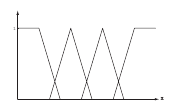

Figure 4.23: “Category membership” functions, derived from the designer’s prior knowledge, together with a lead to discriminants. In this ﬁgure x might represent an objectively measureable value such as the reﬂectivity of a ﬁsh’s skin. The designer believes there are four relevant ranges, which might be called dark, medium-dark, medium-light and light. Note, the memberships are not in true categories we wish to classify, but instead merely ranges of feature values.

## Fuzzy Classification

## Overview

Fuzzy classification involves converting objective measurements into "category memberships," where each category represents an overlapping range of feature values. These memberships are used to classify an object, such as a fish, into categories based on multiple features (e.g., lightness, shape).

### Example

Let's consider two features:
- **Lightness**: Categories like "dark," "medium-dark," "medium," "medium-light," and "light."
- **Shape**: Categories like "oblong," "stout."

### Fuzzy Membership Functions

For the feature **lightness**, we define the following fuzzy membership functions:
$$
\mu_{\text{light}}(x) = \begin{cases} 
1 & \text{if } x \text{ is light} \\
0 & \text{if } x \text{ is dark}
\end{cases}
$$

### Conjunction Rule

To combine multiple feature memberships (lightness and shape), we use the **MIN** rule:
$$
\text{Conjunction} = 1 - \min(\mu_{\text{light}}(x), \mu_{\text{oblong}}(y))
$$

Where:
- $ \mu_{\text{light}}(x) $ is the membership of feature $ x $ in the "light" category.
- $ \mu_{\text{oblong}}(y) $ is the membership of feature $ y $ in the "oblong" category.

### Extension to Multiple Features

For $ n $ features, the conjunction rule becomes:
$$
\text{Conjunction} = 1 - \min\left(\mu_1(x_1), \mu_2(x_2), \dots, \mu_n(x_n)\right)
$$


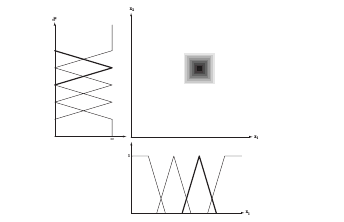

Fig.24: “Category membership” functions and a conjunction rule based on the designer’s prior knowledge lead to discriminant functions. Here x1 and x2 are objectively measurable feature values. The designer believes that a particular class can be described as the conjunction of two “category memberships,” here shown bold. Here the conjunction rule of Eq. 65 is used to give the discriminant function. The resulting discriminant function for the ﬁnal category is indicated by the grayscale in the middle: the greater the discriminant, the darker. The designer constructs discriminant func- tions for other categories in a similar way (possibly also using disjunctions). During classiﬁcation, the maximum discriminant function is chosen.

###  Are Fuzzy Category Memberships Just Probabilities?

Even before the introduction of fuzzy methods and category membership functions, the statistics, pattern recognition, and even mathematical philosophy communities argued a great deal over the fundamental nature of probability. Some questioned the applicability of the concept to single, non-repeatable events, feeling that statements about a single event — for example, "What was the probability of rain on Tuesday?" — were meaningless. 

Such discussions made it clear that “probability” need not apply only to repeatable events. Instead, since the first half of the 20th century, probability has been used as the logic of reasonable inference — work that highlighted the notion of subjective probability. Moreover, pattern recognition practitioners had happily used discriminant functions without concern over whether they represented probabilities, subjective probabilities, approximations to frequencies, or other fundamental entities.

While a full analysis of these topics would lead us away from our development of pattern recognition techniques, it pays to consider the claims of fuzzy logic proponents. To be a good pattern recognition practitioner, we must understand what is or is not afforded by any technique. 

Proponents of fuzzy logic argue that category membership functions do not represent probabilities — subjective or not. For instance, consider the example of placing half a teaspoon of sugar in a cup of tea. The “membership” in the category *sweet* might be 0.5, but it would be incorrect to state that the probability that the tea was sweet is 50%. In this case, one might view this as a sweetness feature value of 0.5, and then use a discriminant function, whose arguments include this feature value. 

Rather than debating the fundamental nature of probability, we should be concerned with the nature of inference — how we take measurements and infer a category. Cox’s axioms (also called Cox-Jaynes axioms) provide a basis for understanding subjective probability in the context of reasoning:

1. If $ P(a|d) > P(b|d) $ and $ P(b|d) > P(c|d) $, then $ P(a|d) > P(c|d) $. That is, degrees of belief have a natural ordering, given by real numbers.
2. $ P(\text{not } a | d) = F_1[P(a | d)] $. This means that the degree of belief that a proposition is not true is some function $ F_1 $ of the degree of belief that it is true.
3. $ P(a, b | d) = F_2 [P(a | d), P(b | a, d)] $. The degree of belief in both $ a $ and $ b $, given $ d $, is a function of the individual probabilities.

From these axioms, along with classical inference, we derive the laws of probability. Any consistent inference method is formally equivalent to standard probabilistic inference.

In spite of these foundational debates, many practitioners are happy to use fuzzy logic, feeling that “whatever works” should be part of their repertoire. However, it is important to understand both the strengths and limitations of fuzzy methods.

#### Limitations of Fuzzy Methods:

- **Limited Use in High Dimensions**: Fuzzy methods are of limited use in high dimensions or complex problems. Pure fuzzy methods contribute little to problems with many features or large datasets.
  
- **Limited Information from the Designer**: The amount of knowledge the designer can provide is restricted — for example, the number, positions, and widths of "category memberships."
  
- **Lack of Normalization**: Fuzzy methods are poorly suited for problems with changing cost matrices, where normalization is required.

- **No Use of Training Data**: Pure fuzzy methods do not make use of training data. This is a significant drawback when dealing with moderate-sized or complex problems.

#### Hybrid Approaches:

When pure fuzzy methods fail to produce satisfactory results, it has been common to incorporate adaptive techniques, such as "neuro-fuzzy" methods. These methods combine the benefits of fuzzy logic with adaptive learning techniques, allowing for a better fit to real-world problems. At best, these methods are equivalent to maximum likelihood methods.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define fuzzy membership functions for two features
def lightness_membership(x):
    """
    Membership function for lightness feature
    x: feature value (e.g., brightness of the fish)
    Returns the membership degree in the categories: dark, medium-dark, medium-light, light
    """
    if x < 0.2:
        return [1, 0, 0, 0]  # dark
    elif x < 0.4:
        return [0.5, 0.5, 0, 0]  # medium-dark
    elif x < 0.6:
        return [0, 0.5, 0.5, 0]  # medium-light
    elif x < 0.8:
        return [0, 0, 0.5, 0.5]  # light
    else:
        return [0, 0, 0, 1]  # lightest

def shape_membership(x):
    """
    Membership function for shape feature
    x: feature value (e.g., elongation or roundness of the fish)
    Returns the membership degree in the categories: oblong, round
    """
    if x < 0.2:
        return [1, 0]  # oblong
    elif x < 0.8:
        return [0, 1]  # round
    else:
        return [0, 1]  # round

# Conjunction rule: Minimum of the memberships
def conjunction_rule(lightness, shape):
    """
    Apply the fuzzy conjunction rule (min rule) to combine the two features' membership degrees
    lightness: List of membership degrees for the lightness feature
    shape: List of membership degrees for the shape feature
    Returns the combined membership degrees for each category
    """
    return [min(lightness[i], shape[i]) for i in range(min(len(lightness), len(shape)))]

# Example fish features
lightness_value = 0.5  # A feature value for lightness (from 0 to 1)
shape_value = 0.4      # A feature value for shape (from 0 to 1)

# Compute membership degrees for both features
lightness_deg = lightness_membership(lightness_value)
shape_deg = shape_membership(shape_value)

# Apply the conjunction rule
combined_membership = conjunction_rule(lightness_deg, shape_deg)

# Print the results
print("Lightness membership:", lightness_deg)
print("Shape membership:", shape_deg)
print("Combined membership (using conjunction rule):", combined_membership)

# Plot the results for visualization
categories = ['dark', 'medium-dark', 'medium-light', 'light']
plt.bar(categories, combined_membership, color='skyblue')
plt.xlabel("Category")
plt.ylabel("Membership Degree")
plt.title(f"Fuzzy Classification for Fish: Lightness={lightness_value}, Shape={shape_value}")
plt.show()


Lightness membership: [0, 0.5, 0.5, 0]
Shape membership: [0, 0.5, 0.5, 0]
Combined membership (using conjunction rule): [0, 0.5, 0.5, 0]


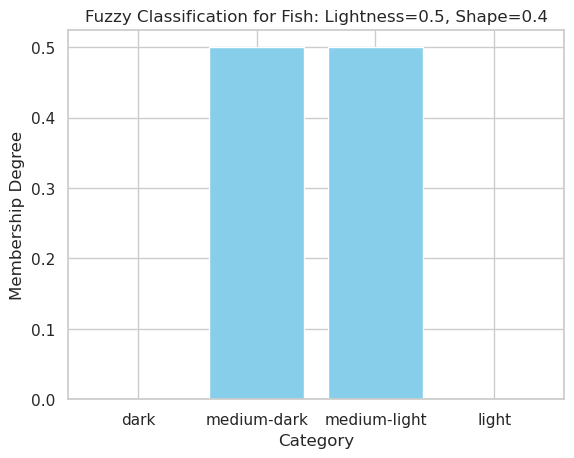

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Define fuzzy membership functions for two features (lightness and shape)
def lightness_membership(x):
    """
    Membership function for lightness feature.
    x: feature value (e.g., brightness of the fish).
    Returns the membership degree in the categories: dark, medium-dark, medium-light, light.
    """
    if x < 0.2:
        return [1, 0, 0, 0]  # dark
    elif x < 0.4:
        return [0.5, 0.5, 0, 0]  # medium-dark
    elif x < 0.6:
        return [0, 0.5, 0.5, 0]  # medium-light
    elif x < 0.8:
        return [0, 0, 0.5, 0.5]  # light
    else:
        return [0, 0, 0, 1]  # lightest

def shape_membership(x):
    """
    Membership function for shape feature.
    x: feature value (e.g., elongation or roundness of the fish).
    Returns the membership degree in the categories: oblong, medium-oblong, round, very-round.
    """
    if x < 0.2:
        return [1, 0, 0, 0]  # oblong
    elif x < 0.4:
        return [0.5, 0.5, 0, 0]  # medium-oblong
    elif x < 0.6:
        return [0, 0.5, 0.5, 0]  # round
    elif x < 0.8:
        return [0, 0, 0.5, 0.5]  # very-round
    else:
        return [0, 0, 0, 1]  # very-round

# Conjunction rule: Minimum of the memberships
def conjunction_rule(lightness, shape):
    """
    Apply the fuzzy conjunction rule (min rule) to combine the two features' membership degrees.
    lightness: List of membership degrees for the lightness feature.
    shape: List of membership degrees for the shape feature.
    Returns the combined membership degrees for each category.
    """
    return [min(lightness[i], shape[i]) for i in range(min(len(lightness), len(shape)))]

# Example fish features
lightness_value = 0.5  # A feature value for lightness (from 0 to 1)
shape_value = 0.4      # A feature value for shape (from 0 to 1)

# Compute membership degrees for both features
lightness_deg = lightness_membership(lightness_value)
shape_deg = shape_membership(shape_value)

# Apply the conjunction rule
combined_membership = conjunction_rule(lightness_deg, shape_deg)

# Print the results
print("Lightness membership:", lightness_deg)
print("Shape membership:", shape_deg)
print("Combined membership (using conjunction rule):", combined_membership)

# Plot the results for visualization
categories = ['dark', 'medium-dark', 'medium-light', 'light']
plt.bar(categories, combined_membership, color='skyblue')
plt.xlabel("Category")
plt.ylabel("Membership Degree")
plt.title(f"Fuzzy Classification for Fish: Lightness={lightness_value}, Shape={shape_value}")
plt.show()


## Relaxation Methods in Pattern Recognition

In pattern recognition, the **Parzen-window method** uses a fixed window throughout the feature space, which can lead to difficulties. In some regions, a small window width may be appropriate, while in others, a larger one would be better. The **k-nearest-neighbor method** addresses this problem by adjusting the region based on the density of the points. An intermediate approach between these two is to adjust the size of the window during training, based on the distance to the nearest point of a different category. This is the basis for **relaxation techniques**.

### Potential Functions

The simplest method of relaxation is the use of **potential functions**. These functions modify the magnitude of the window during training to properly classify the training data. A representative method of this kind is the **Reduced Coulomb Energy (RCE) network**.

The RCE network has the same topology as a **Probabilistic Neural Network (PNN)**, but with an important difference: in an RCE network, each pattern unit has an adjustable **radius parameter** $ \lambda $. During training, this radius is adjusted such that each unit covers a region as large as possible, without including points from a different category.

### RCE Network Training Algorithm

The RCE training algorithm works as follows:

1. **Initialization**: Set $ j = 0 $, $ n = \text{number of patterns} $, $ \lambda_m = \text{maximum radius} $, and a small parameter $ \epsilon $.
2. **Iterate Over Training Patterns**:
   - For each training point $ x_k $, set the weight of the pattern unit as $ w_{jk} = x_k $.
   - Find the nearest pattern not in category $ \omega_i $, denoted as $ \hat{x} $.
   - Set the radius for the pattern unit as $ \lambda_j = \min[D(x, \hat{x}) - 1, \lambda_m] $, where $ D(x, \hat{x}) $ is the distance between the test pattern and the nearest point of another category.
   - If $ x \in \omega_i $, set the activation as $ a_{ic} = 1 $.
3. **Repeat** until all training patterns are processed.

### RCE Network Classification Algorithm

For classification, given a test point $ x $:

1. **Initialize**: Set $ j = 0 $, $ k = 0 $, and $ D_t = \emptyset $, which will hold the set of prototypes whose hyperspheres contain the test point.
2. **Iterate Over Pattern Units**:
   - For each pattern unit, check if $ D(x, w_j) < \lambda_j $. If so, add the prototype $ w_j $ to $ D_t $.
3. **Classification**:
   - If all prototypes in $ D_t $ belong to the same category, return the label of the prototypes.
   - If the prototypes in $ D_t $ belong to multiple categories, return "ambiguous."

### Visual Representation of RCE Training
![image.png](attachment:image.png)
Figu.26: During training, each pattern has a parameter — equivalent to a radius in the d-dimensional space — that is adjusted to be as large as possible, without enclosing any points from a diﬀerent category. As new patterns are presented, each such radius is decreased accordingly (and can never increase). In this way, each pattern unit can enclose several prototypes, but only those having the same category label. The number of points is shown in each component ﬁgure. The ﬁgure at the bottom shows the ﬁnal complicated decision regions, colored by category.

![image-2.png](attachment:image-2.png)


Fig.25: An RCE network is topologically equivalent to the PNN of Fig.9. During training the wghts are adjusted to have the same values as the pattern presented, just as in a PNN. However, pattern units in an RCE network also have a modiﬁable “radius” parameter λ. During training, each λ is adjusted so that the region is as large as possible without containing training patterns from a diﬀerent category.

In the training phase, each pattern unit is associated with a **radius** (in $ d $-dimensional space). The radius is adjusted to be as large as possible without including any points from a different category. As training progresses, these radii decrease, and the decision regions become more complicated.

#### Diagram of RCE Network

```plaintext
          Pattern Units
      -------------------------
     |  Category 1   |  Category 2 |
     |   \lambda_1   |   \lambda_2  |
     |               |             |
     |      ...      |      ...     |
     -------------------------


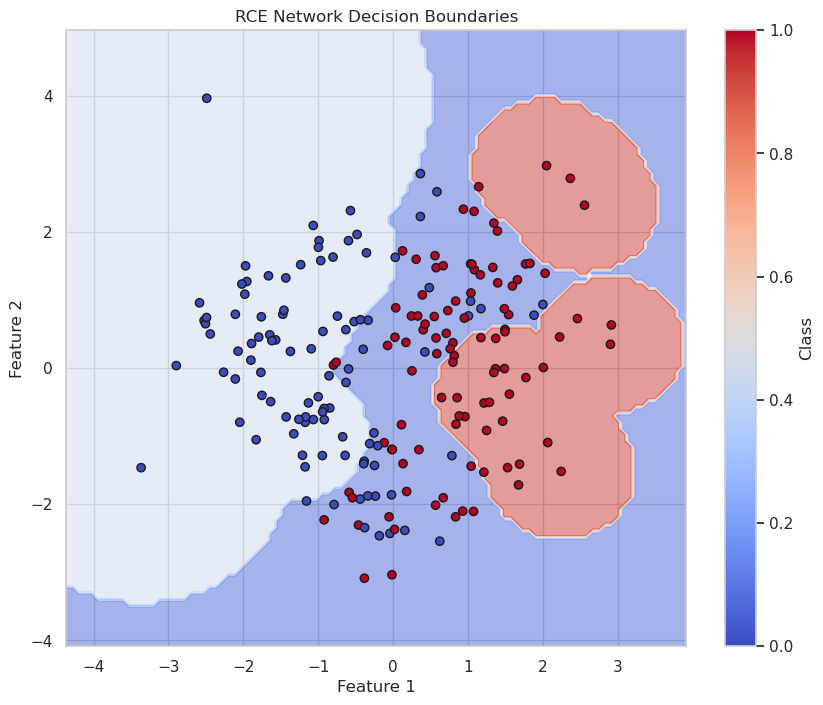

Test point [0.5 0.5] is classified as: -1


In [20]:
# Function to classify a new test point (with numerical encoding for ambiguity)
def rce_classify(X, y, test_point, weights, radii):
    distances = np.linalg.norm(X - test_point, axis=1)
    relevant_indices = distances < radii  # Find all units within radius
    if np.sum(relevant_indices) == 0:
        return -1  # Ambiguous
    
    # Get the classes of the relevant pattern units
    relevant_labels = y[relevant_indices]
    
    # If all relevant points belong to the same class, return that class
    if np.all(relevant_labels == relevant_labels[0]):
        return relevant_labels[0]
    
    return -1  # Ambiguous

# Create a numerical map for ambiguous regions and class labels
numerical_predictions = np.array([rce_classify(X, y, point, weights, radii) for point in grid_points])
numerical_predictions = numerical_predictions.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(10, 8))
# Plot the decision regions
plt.contourf(xx, yy, numerical_predictions, alpha=0.5, cmap='coolwarm')
# Plot the data points
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm', marker='o')
plt.title("RCE Network Decision Boundaries")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(label="Class")
plt.show()

# Example classification
test_point = np.array([0.5, 0.5])  # Example test point
prediction = rce_classify(X, y, test_point, weights, radii)
print(f"Test point {test_point} is classified as: {prediction}")
